In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
#사고율이 10을 넘는 관측치는 이상치로 판단해 모델링 과정에서 제거
mdl_df=df[df['사고율']<=10]

In [4]:
#사고율이 높은 고객 탐지 성능 향상을 위해 고위험군으로 의심되는 고객을 선별적으로 분류하는 이진 분류 모델링 진행
mdl_df['고위험']=0
mdl_df.loc[mdl_df['사고율']>=1,'고위험']=1

C:\Users\EunSeon\AppData\Local\Temp\ipykernel_10660\832155598.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mdl_df['고위험']=0


In [5]:
mdl_df=mdl_df.drop(['유효대수','사고건수'],axis=1)
X=mdl_df.drop(['고위험','사고율'],axis=1)
y=mdl_df['고위험']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=831)

In [6]:
X=X_train
y=y_train

In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134084 entries, 100664 to 105564
Data columns (total 15 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   피보험자연령대      134084 non-null  int64
 1   피보험자성별       134084 non-null  int64
 2   국산구분         134084 non-null  int64
 3   직전3년간사고건수    134084 non-null  int64
 4   차량경과년수       134084 non-null  int64
 5   차종           134084 non-null  int64
 6   운전자한정특별약관    134084 non-null  int64
 7   가입경력         134084 non-null  int64
 8   차량가입금액       134084 non-null  int64
 9   영상기록장치특약     134084 non-null  int64
 10  마일리지약정거리     134084 non-null  int64
 11  마일리지약정_가입여부  134084 non-null  int64
 12  자차보험_가입여부    134084 non-null  int64
 13  고경력운전자       134084 non-null  int64
 14  저경력운전자       134084 non-null  int64
dtypes: int64(15)
memory usage: 16.4 MB


In [8]:
#One-hot Encoding
#파이썬 logistic regression은 범주형 자료에 대해 따로 One-hot Encoding을 진행해주지 않기 때문
X = pd.get_dummies(X, columns = ['직전3년간사고건수','운전자한정특별약관'], drop_first = False)

In [9]:
#유의하지 않았던 변수 제거
X=X.drop(['차량경과년수','마일리지약정거리','자차보험_가입여부','저경력운전자','직전3년간사고건수_5','운전자한정특별약관_1','운전자한정특별약관_2','운전자한정특별약관_5','운전자한정특별약관_6','운전자한정특별약관_10'],axis=1)

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, auc, accuracy_score
from sklearn.metrics import matthews_corrcoef

In [11]:
model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X, y)

LogisticRegression(max_iter=1000)

In [12]:
X_test = pd.get_dummies(X_test, columns = ['직전3년간사고건수','운전자한정특별약관'], drop_first = False)
X_test=X_test.drop(['차량경과년수','마일리지약정거리','자차보험_가입여부','저경력운전자','직전3년간사고건수_5','운전자한정특별약관_1','운전자한정특별약관_2','운전자한정특별약관_5'],axis=1)

In [13]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1] 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

In [14]:
roc_auc = auc(fpr, tpr)
roc_auc

0.6573155247105468

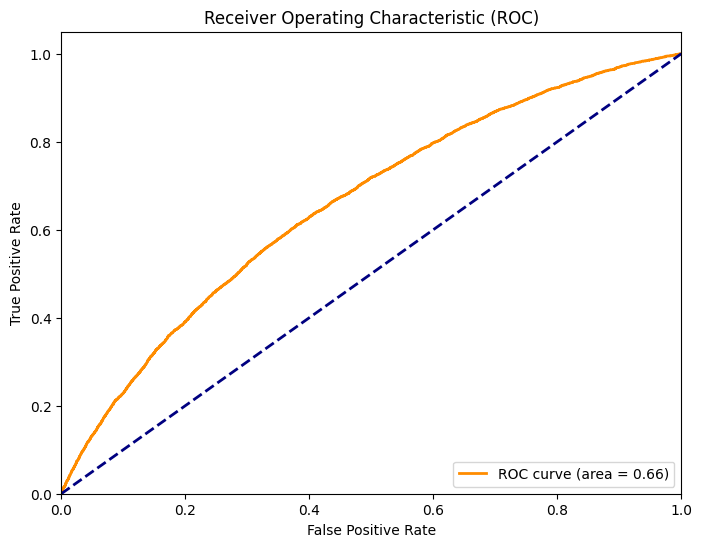

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [16]:
optimal_idx=np.argmax(tpr-fpr)
optimal=thresholds[optimal_idx]

optimal

0.13675013563077576

In [17]:
#optimal threshold로 logistic regression 진행
model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X,y)
threshold=optimal
y_prob=model.predict_proba(X_test)[:,1]
y_pred=(y_prob>threshold).astype(int)

In [18]:
test_pred=pd.DataFrame(y_pred,columns=['고위험군 예측'])
idx=X_test.index
test_pred.set_index(idx,inplace=True)
result=pd.concat([X_test,y_test],axis=1)
result=pd.concat([result,test_pred],axis=1)
result.drop('고위험',axis=1,inplace=True)
result.head()

,피보험자연령대,피보험자성별,국산구분,차종,가입경력,차량가입금액,영상기록장치특약,마일리지약정_가입여부,고경력운전자,직전3년간사고건수_1,직전3년간사고건수_2,직전3년간사고건수_3,직전3년간사고건수_4,운전자한정특별약관_3,운전자한정특별약관_4,운전자한정특별약관_7,운전자한정특별약관_11,운전자한정특별약관_12,고위험군 예측
6579,2,1,0,2,3,2,1,1,0,0,0,1,0,1,0,0,0,0,1
124520,6,0,1,2,5,2,1,1,0,1,0,0,0,1,0,0,0,0,0
148325,8,1,0,4,8,2,0,1,0,0,0,1,0,1,0,0,0,0,0
24449,3,0,0,5,2,2,1,1,0,1,0,0,0,0,0,0,0,0,1
5590,2,0,1,3,2,2,1,0,0,1,0,0,0,0,1,0,0,0,1


In [19]:
result=pd.concat([result,mdl_df.loc[idx]['사고율']],axis=1)

In [20]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
report = classification_report(y_test, y_pred)
print("분류 보고서:\n", report)

분류 보고서:
               precision    recall  f1-score   support

           0       0.91      0.62      0.74     28748
           1       0.21      0.61      0.31      4773

    accuracy                           0.62     33521
   macro avg       0.56      0.62      0.52     33521
weighted avg       0.81      0.62      0.68     33521



In [24]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.618835953581337

In [21]:
f1_score(y_test,y_pred)

0.3134705281822578

In [22]:
f1_score(y_test,y_pred,average='macro')

0.5248259498089543

In [23]:
confusion = confusion_matrix(y_test,y_pred)
confusion

array([[17827, 10921],
       [ 1856,  2917]], dtype=int64)

In [160]:
result.to_csv('test_dataset.csv',index=False,encoding='cp949')